# CRF tagging for Movie Queries Data

In [1]:
pip install python-crfsuite

     |████████████████████████████████| 743 kB 5.0 MB/s 


In [2]:
import os
import sys
import pandas as pd
from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np
import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO (Beginning, Inside, Outside) tagged corpus, tab separated and each example sentence/text separated by a blank line and tuples of (word, tag) tuples are returned in a list."""
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [5]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [6]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [7]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [8]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [9]:
training_data = [preProcess(example) for example in raw_training_data]

In [10]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [11]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extracts basic features about this word including
         - Current Word
         - Capitalized 
         - Punctuation 
         - Number 
         - Suffixes up to length 3

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [12]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [13]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file
# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [15]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


## Top 5 classes which have the lowest precision (False positive)

In [16]:
rep=classification_report(y_test, preds, output_dict=True)
v=[]
for i,j in rep.items():
    if((i!='accuracy') and (i!='macro avg')and (i!='weighted avg')):
        for a,b in j.items():
            if(a=='precision'):
                v.append((i,a,b))

df=pd.DataFrame(v,columns=['col1','col2','col3'])
df_sort=df.sort_values('col3',ascending=True)
df_sort.head()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,col1,col2,col3
22,I-TRAILER,precision,0.000000
19,I-REVIEW,precision,0.000000
7,B-REVIEW,precision,0.142857
16,I-PLOT,precision,0.490854
9,B-TITLE,precision,0.578732


## Top 5 classes which have the lowest recall(False Negative)

In [20]:
rep=classification_report(y_test, preds, output_dict=True)
v1=[]
for i,j in rep.items():
    if((i!='accuracy') and (i!='macro avg')and (i!='weighted avg')):
        for a,b in j.items():
            if(a=='recall'):
                v1.append((i,a,b))

df1=pd.DataFrame(v1,columns=['col1','col2','col3'])
df_sort1=df1.sort_values('col3',ascending=True)
df_sort1.head()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,col1,col2,col3
22,I-TRAILER,recall,0.000000
19,I-REVIEW,recall,0.000000
7,B-REVIEW,recall,0.017857
8,B-SONG,recall,0.166667
20,I-SONG,recall,0.218487


In [17]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.76      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.78      0.61      0.69       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.84       451
         B-REVIEW       0.14      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

In [23]:
words = ["john", "likes", "mary", "and", "bill"]
print(ct.tag(words))

[('john', 'B-TITLE'), ('likes', 'I-TITLE'), ('mary', 'I-TITLE'), ('and', 'I-TITLE'), ('bill', 'I-TITLE')]


In [18]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

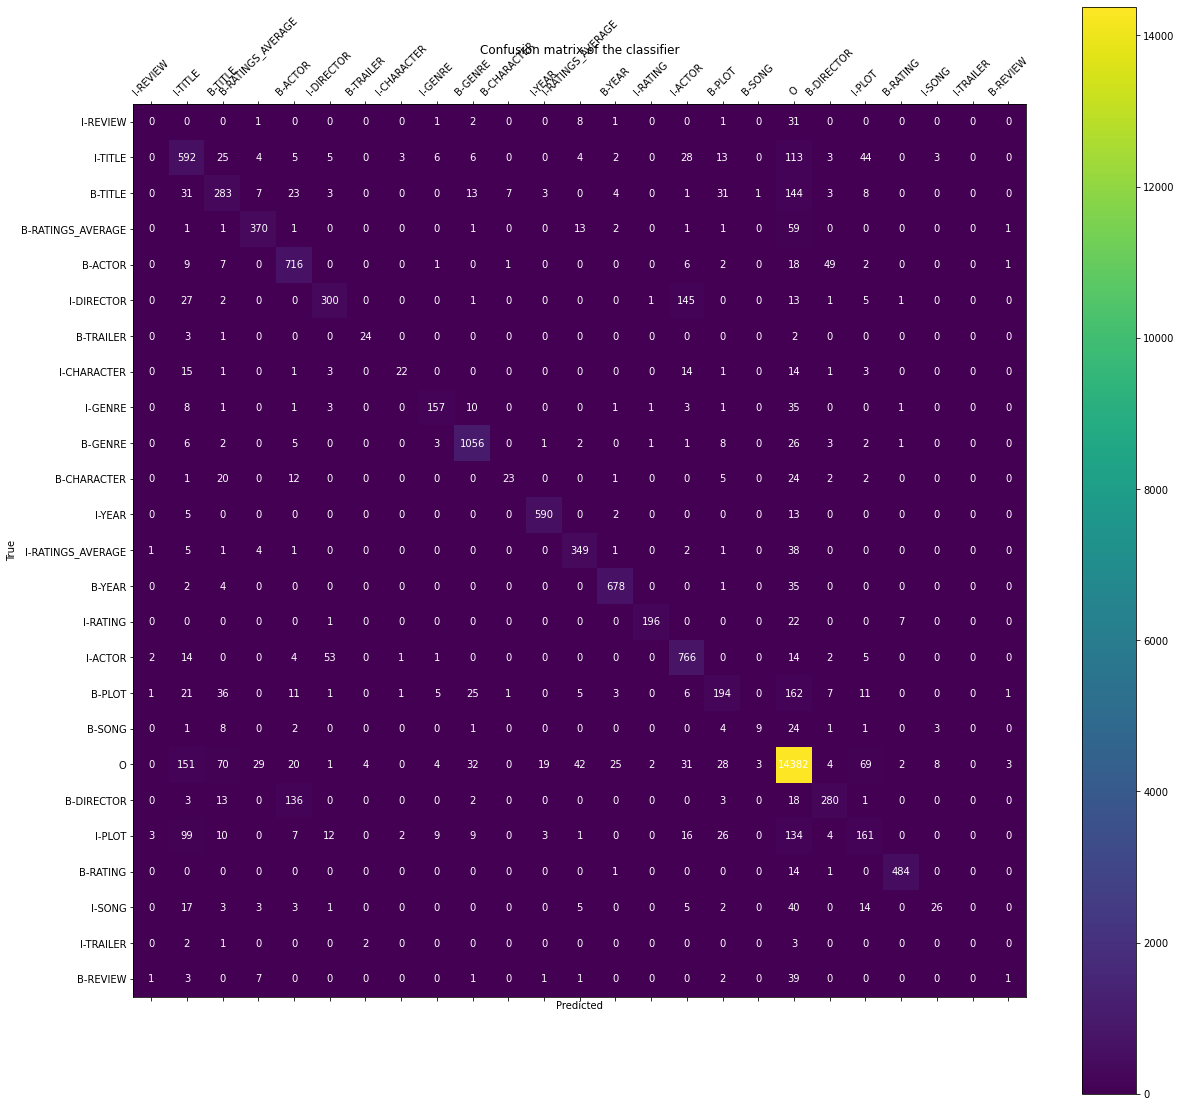

In [19]:
confusion_matrix_heatmap(y_test, preds)

We obtained highest accuracy after adding captializations,numbers, punctuarions, suffixes as feature to tagger.Also, we gave BIO tags and POS tags for training model.To obtain these results we experimneted with different features each time and decided appropriate feature using accuracy as metric.Now the woprd are tagged most accurately.